In [269]:
import pandas

In [270]:
df1 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data.csv')
df2 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data5:37.csv')
df3 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data5:47.csv')
df4 = pandas.read_csv('/home/scv/code/sengoku-attendance-bot/data6:37.csv')

In [271]:
print(df1["number"].isna().mean() * 100)
print(df2["number"].isna().mean() * 100)
print(df3["number"].isna().mean() * 100)
print(df4["number"].isna().mean() * 100)

22.8643216080402
26.884422110552762
27.1356783919598
13.651591289782244


In [272]:
percent = (df1["number"].isna() & df2["number"].isna() & df3["number"].isna() & df4["number"].isna()).mean() * 100
print(percent)

2.3450586264656614


In [273]:
import pandas as pd

def bigger_half(a, b):
    return a + b / 2

def merge_number_columns(df1: pd.DataFrame, df2: pd.DataFrame, col: str = "number") -> pd.Series:
    s1 = df1[col]
    s2 = df2[col]

    return s1.combine(s2, lambda a, b: bigger_half(a, b) if pd.notna(a) and pd.notna(b) else a if pd.notna(a) else b)

In [274]:
print(df1["number"].mean(), df2["number"].mean(), df3["number"].mean(), df4["number"].mean())

33.01028230184582 33.66439862542955 31.749942528735637 31.9221629485936


In [275]:
df = pandas.DataFrame()
df["number"] = merge_number_columns(df1, df2)
df["number"] = merge_number_columns(df, df3)
df["number"] = merge_number_columns(df, df4)
df["date"] = df1["date"]
df["link"] = df1["link"]
df = df[df["number"] <= 65]
print(df["number"].isna().mean() * 100)
print(df["number"].mean())

0.0
38.5013973063973


In [276]:
df = df.dropna(subset=["number"])

q1 = df["number"].quantile(0.25)
q3 = df["number"].quantile(0.75)
iqr = q3 - q1

df = df[(df["number"] >= q1 - 1.5 * iqr) & (df["number"] <= q3 + 1.5 * iqr)]

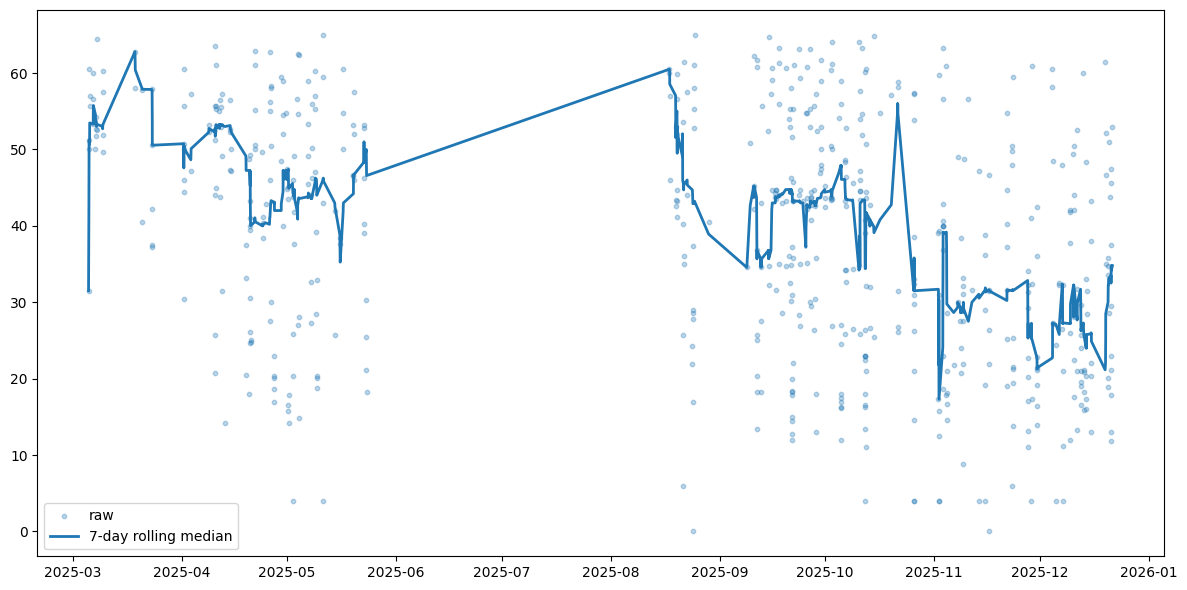

In [277]:
import matplotlib.pyplot as plt

df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)
df = df.dropna(subset=["date", "number"])


df = df.sort_values("date")

plt.figure(figsize=(12, 6))

# сырые точки
plt.scatter(
    df["date"],
    df["number"],
    s=10,
    alpha=0.3,
    label="raw"
)

df = df.set_index("date")
# сглаживание: rolling median (устойчив к выбросам)
smoothed = (
    df
    ["number"]
    .rolling("7D", min_periods=1)
    .median()
)

plt.plot(
    smoothed.index,
    smoothed.values,
    linewidth=2,
    label="7-day rolling median"
)

plt.legend()
plt.tight_layout()
plt.show()


In [278]:
df_hi = df[df["number"] > 30]
df_hi = df_hi[df_hi["number"] < 65]
df_lo = df[df["number"] <= 30]

In [ ]:
import matplotlib.pyplot as plt

def plot_ts(df: pandas.DataFrame, title):
    df = df.sort_values("date")

    plt.figure(figsize=(12, 5))

    plt.scatter(
        df.index,
        df["number"],
        s=10,
        alpha=0.3,
        label="raw"
    )

    smoothed = (
        df
        ["number"]
        .rolling("7D", min_periods=1)
        .median()
    )

    plt.plot(
        smoothed.index,
        smoothed.values,
        linewidth=2,
        label="7-day rolling median"
    )

    if "real_price" in df.keys():
        smoothed = (
            df
            ["real_price"]
            .rolling("7D", min_periods=1)
            .median()
        )

        plt.plot(
            smoothed.index,
            smoothed.values,
            linewidth=2,
            label="7-day rolling real price",
        )

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


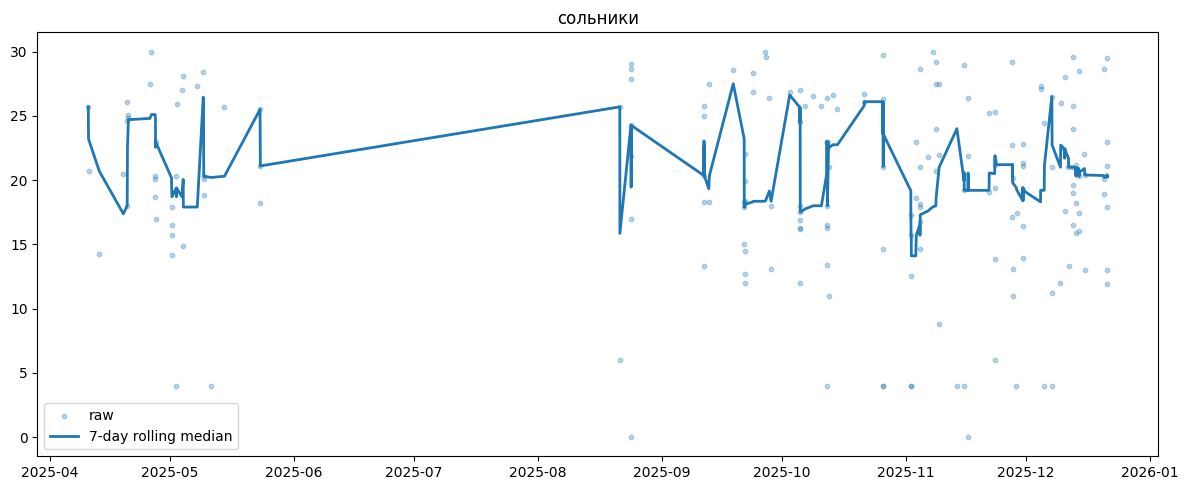

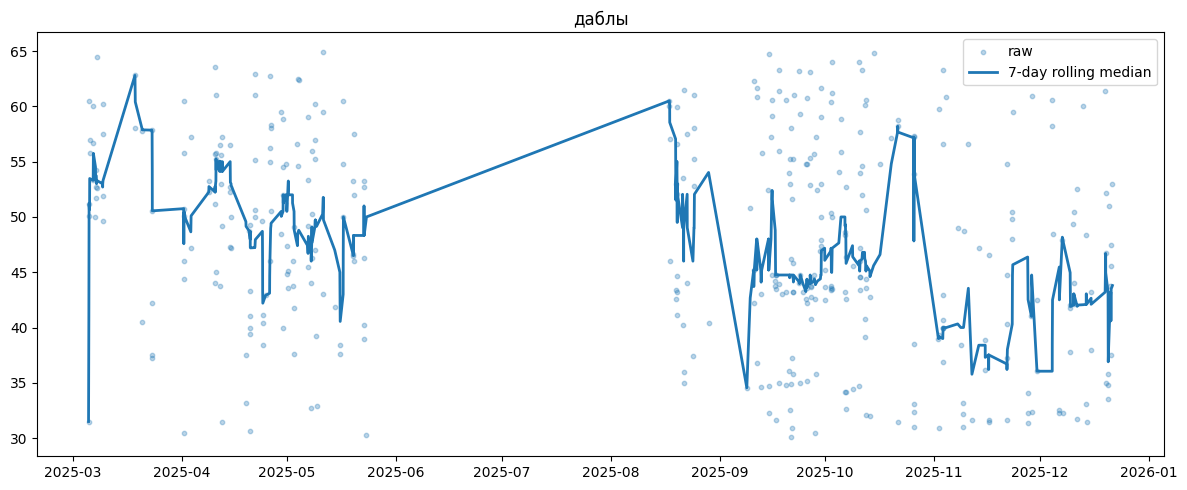

In [305]:
plot_ts(df_lo, "сольники")
plot_ts(df_hi, "даблы")

In [295]:
pct_lo = df_lo["number"].pct_change() * 100
pct_hi = df_hi["number"].pct_change() * 100

low, high = pct_lo.quantile([0.01, 0.99])
pct_lo = pct_lo.clip(low, high)

low, high = pct_hi.quantile([0.01, 0.99])
pct_hi = pct_hi.clip(low, high)


In [296]:
def plot_percent(df_pct):

    plt.figure(figsize=(12, 5))

    plt.plot(df_pct.index, df_pct.values, linewidth=1)
    plt.axhline(0, linestyle="--", alpha=0.5)

    plt.title("Percentage change of price")
    plt.ylabel("% change")
    plt.tight_layout()

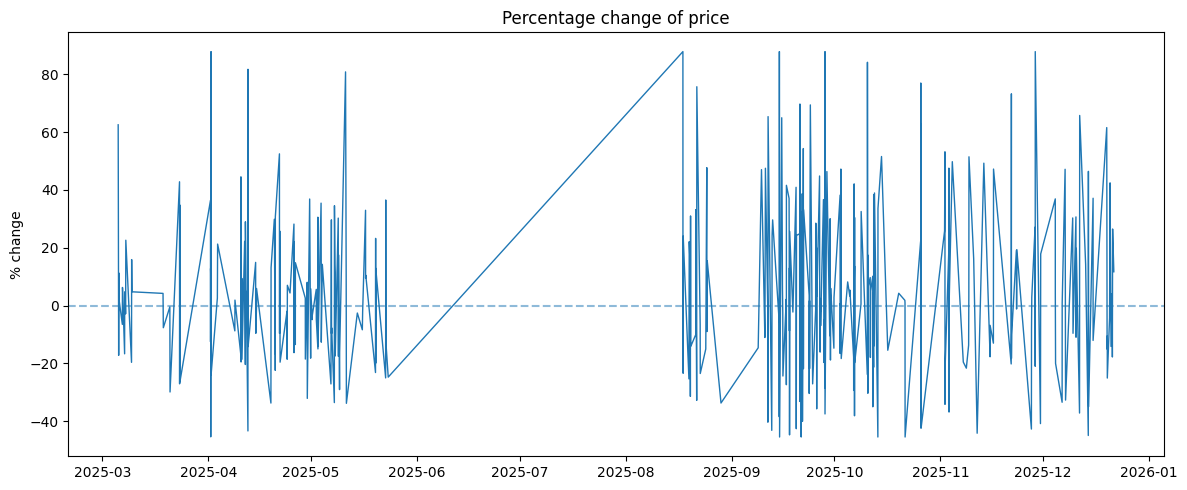

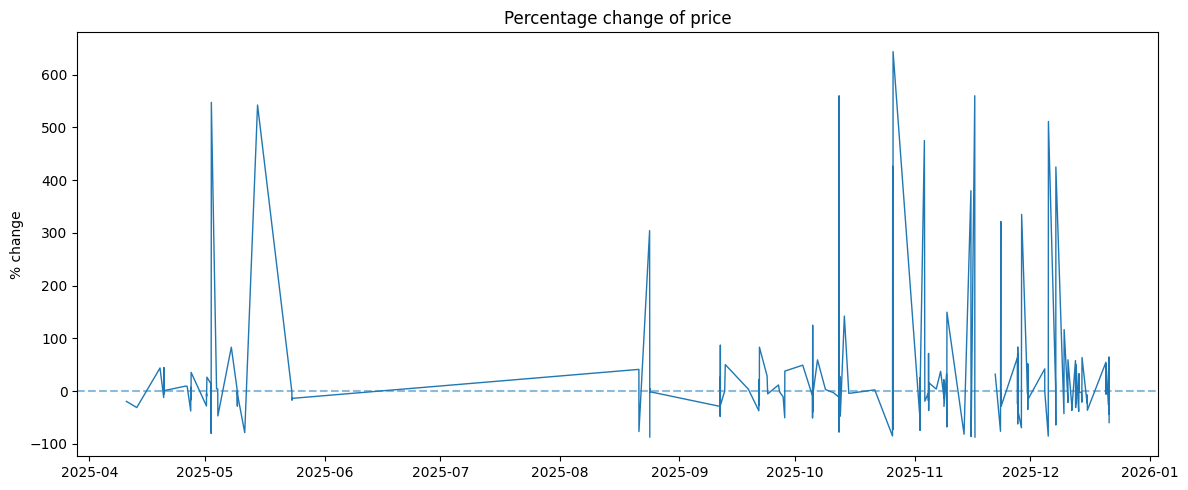

In [297]:
plot_percent(pct_hi)
plot_percent(pct_lo)

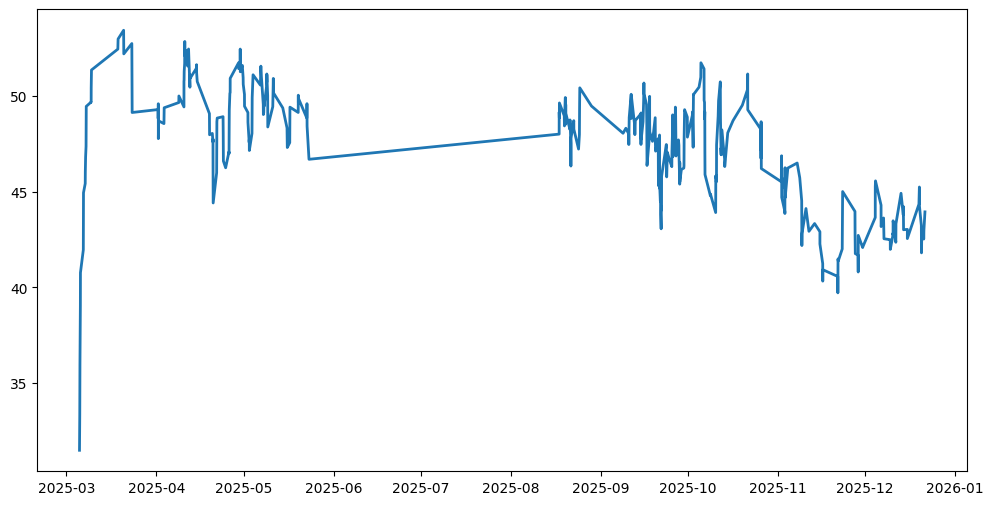

In [284]:
import matplotlib.pyplot as plt

df = df.sort_values("date")

plt.figure(figsize=(12, 6))

ema = (
    df_hi
    ["number"]
    .ewm(span=20, adjust=False)
    .mean()
)

plt.plot(ema.index, ema.values, linewidth=2, label="EMA")



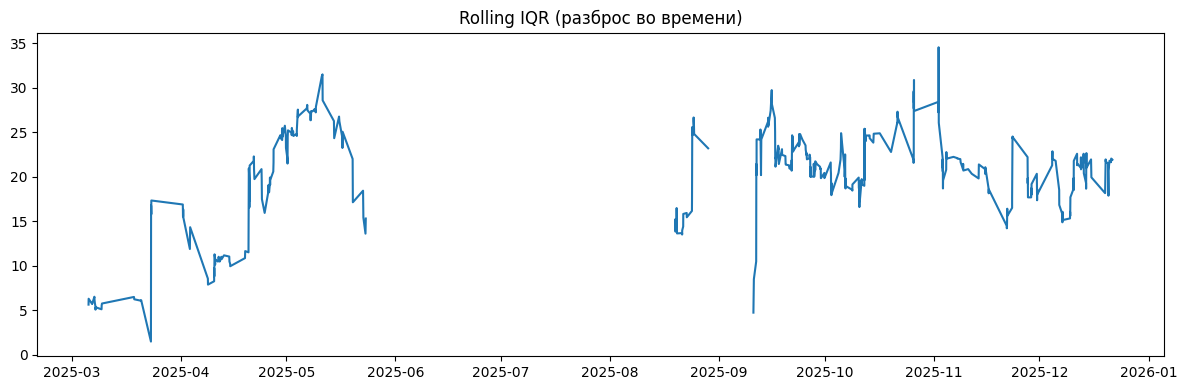

In [285]:
s = df["number"]

q75 = s.rolling("14D", min_periods=5).quantile(0.75)
q25 = s.rolling("14D", min_periods=5).quantile(0.25)
rolling_iqr = q75 - q25

plt.figure(figsize=(12, 4))
plt.plot(rolling_iqr.index, rolling_iqr.values)
plt.title("Rolling IQR (разброс во времени)")
plt.tight_layout()
plt.show()


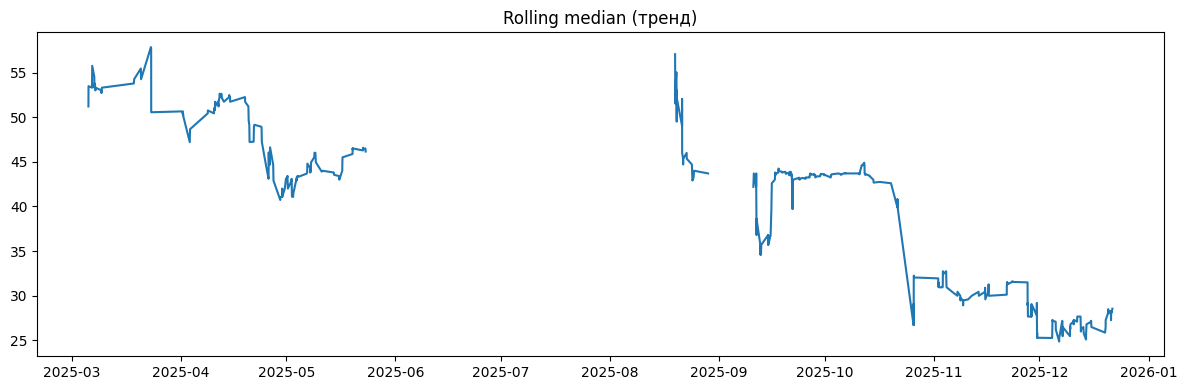

In [286]:
trend = df["number"].rolling("14D", min_periods=5).median()
plt.figure(figsize=(12, 4))
plt.plot(trend.index, trend.values)
plt.title("Rolling median (тренд)")
plt.tight_layout()
plt.show()


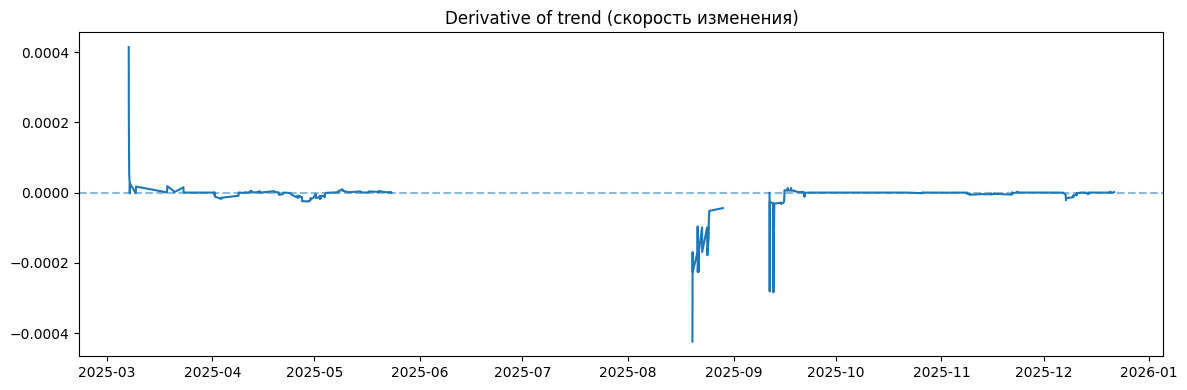

In [287]:
dt = trend.index.to_series().diff().dt.total_seconds()
dtrend = trend.diff() / dt
dtrend_smooth = dtrend.rolling("14D", min_periods=5).median()
plt.figure(figsize=(12, 4))
plt.plot(dtrend_smooth.index, dtrend_smooth.values)
plt.axhline(0, linestyle="--", alpha=0.5)
plt.title("Derivative of trend (скорость изменения)")
plt.tight_layout()
plt.show()


In [288]:
diqr = rolling_iqr.diff()
mid = len(trend) // 2
print(trend.iloc[:mid].median(), trend.iloc[mid:].median())


44.675 31.275


In [289]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
groups = pd.cut(df["number"], bins=bins)

counts = groups.value_counts().sort_index()
print(counts)

number
(0, 10]      15
(10, 20]     72
(20, 30]    107
(30, 40]     91
(40, 50]    136
(50, 60]    124
(60, 70]     46
(70, 80]      0
Name: count, dtype: int64


In [290]:
trend = df["number"].rolling("14D", min_periods=5).median()
dt = trend.index.to_series().diff().dt.total_seconds()
d1 = trend.diff() / dt
d2 = d1.diff() / dt
d1_s = d1.rolling("14D", min_periods=5).median()
d2_s = d2.rolling("14D", min_periods=5).median()


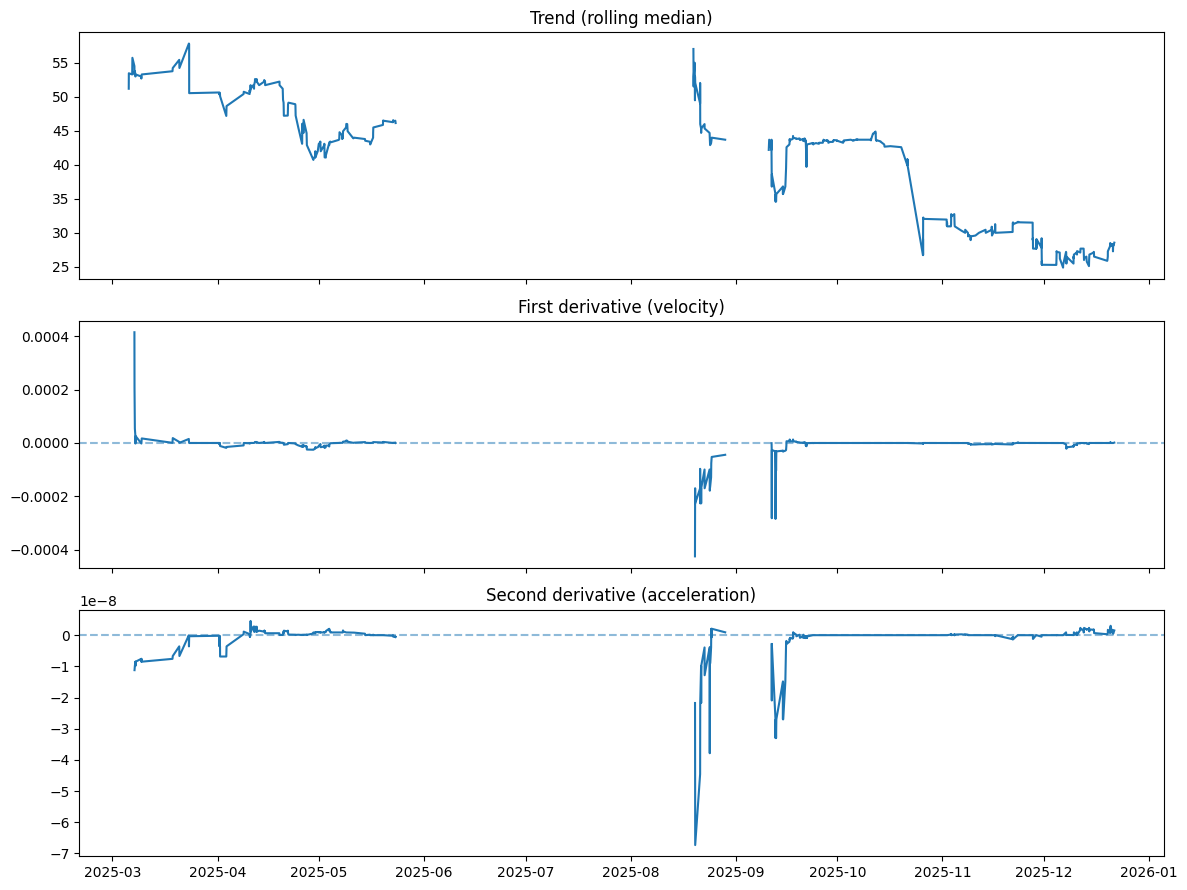

In [291]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# 0 — исходный тренд
axes[0].plot(trend.index, trend.values)
axes[0].set_title("Trend (rolling median)")

# 1 — первая производная
axes[1].plot(d1_s.index, d1_s.values)
axes[1].axhline(0, linestyle="--", alpha=0.5)
axes[1].set_title("First derivative (velocity)")

# 2 — вторая производная
axes[2].plot(d2_s.index, d2_s.values)
axes[2].axhline(0, linestyle="--", alpha=0.5)
axes[2].set_title("Second derivative (acceleration)")

plt.tight_layout()
plt.show()


In [292]:
print(d1_s.dropna().describe())
print(d2_s.dropna().describe())


count    567.000000
mean      -0.000009
std        0.000045
min       -0.000424
25%       -0.000004
50%        0.000000
75%        0.000000
max        0.000414
dtype: float64
count    5.630000e+02
mean    -1.316666e-09
std      6.680997e-09
min     -6.730373e-08
25%     -3.061372e-12
50%      0.000000e+00
75%      5.591263e-10
max      4.554776e-09
dtype: float64


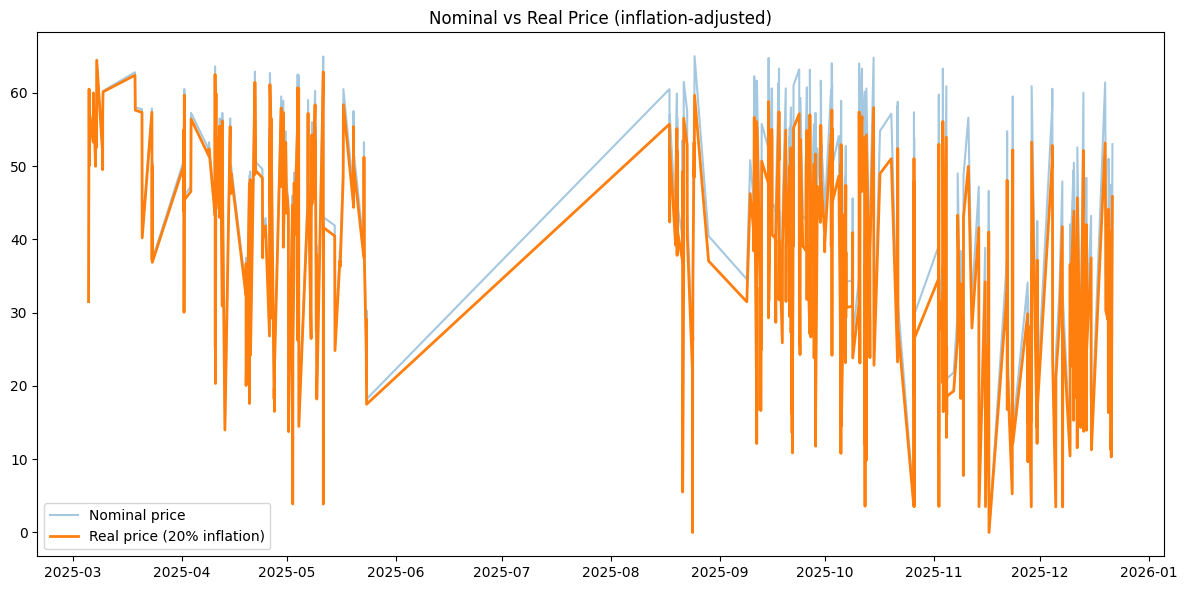

In [302]:
import numpy as np

start_date = df.index.min()
years = (df.index - start_date).days / 365.25


inflation_rate = 0.20
df["real_price"] = df["number"] / ((1 + inflation_rate) ** years)



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df.index, df["number"], alpha=0.4, label="Nominal price")
plt.plot(df.index, df["real_price"], linewidth=2, label="Real price (20% inflation)")

plt.legend()
plt.title("Nominal vs Real Price (inflation-adjusted)")
plt.tight_layout()
plt.show()


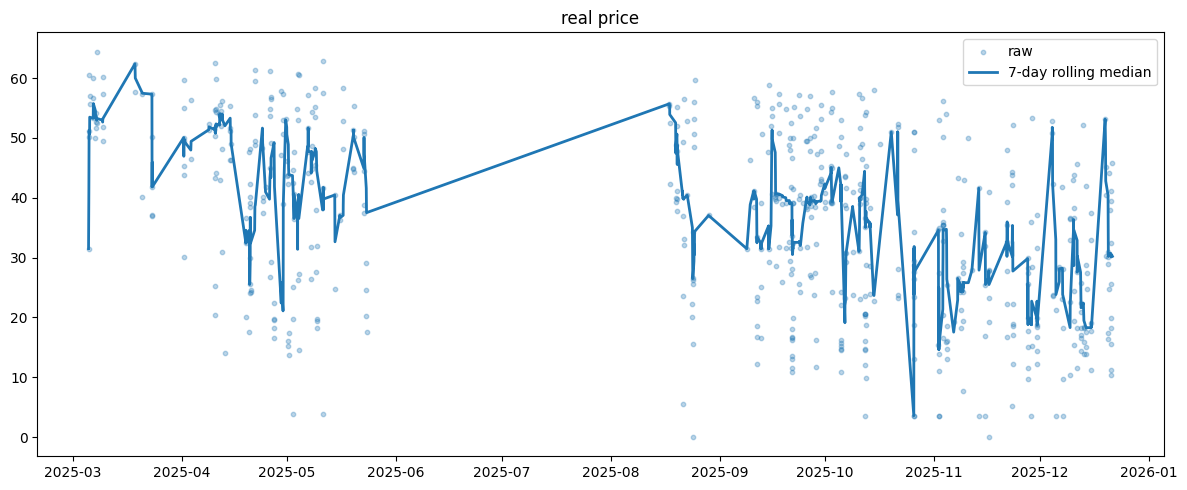

In [303]:
rp_df = df
rp_df["number"] = rp_df["real_price"]
plot_ts(df, "real price")